In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 28.3 MB/s 
     |████████████████████████████████| 880 kB 55.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2a8b5fe99aa8edde847b53ba760e4cda210fbbe9eb6f21f573b468a1776f1b52
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K

In [5]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
# gpus = tf.config.list_physical_devices('GPU')

# tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=15000)])

In [6]:
!gdown --id 104TU-gdBAtalfRyaauuKaOobhGbB52Zf

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=104TU-gdBAtalfRyaauuKaOobhGbB52Zf
To: /content/data.zip
100% 649k/649k [00:00<00:00, 79.3MB/s]


In [7]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: simple-dstc2-trn.json   
  inflating: simple-dstc2-tst.json   
  inflating: simple-dstc2-val.json   
  inflating: slot_vals.json          
  inflating: ner_intent.json         
  inflating: simple-dstc2-templates.txt  
  inflating: ner_intent_test.json    
  inflating: ner_intent_train.json   
  inflating: ner_intent_valid.json   


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def read_json_file(PATH):

  f = open (PATH, 'r')
  data = json.loads(f.read())

  sentences = []
  nertags = []
  intents = []

  for key, value in data.items():
    sentences.append(key)
    nertags.append(' '.join(data[key]['NERTAGS']))
    intents.append(data[key]['INTENTS'])

  f.close()

  return sentences, nertags, intents

In [9]:
train_sentences, train_tags, train_intents = read_json_file('ner_intent_train.json')
test_sentences, test_tags, test_intents = read_json_file('ner_intent_test.json')
valid_sentences, valid_tags, valid_intents = read_json_file('ner_intent_valid.json')

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
def encode_text(tokenizer, text_sequences, max_len):
  input_ids=[]
  attention_masks=[]

  for sent in text_sequences:
    bert_inp = tokenizer.encode_plus(sent, add_special_tokens = True, max_length=max_len, pad_to_max_length = True, 
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

  input_ids = np.asarray(input_ids)
  attention_masks = np.array(attention_masks)

  return input_ids, attention_masks

In [12]:
sent_length = {}

for sent in train_sentences:
  res = len(sent)
  if res in sent_length:
    sent_length[res]+=1
  else:
    sent_length[res]=1

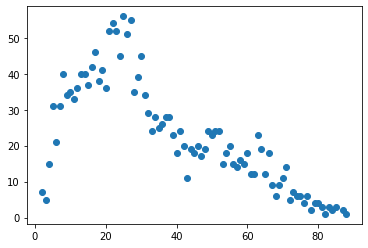

In [13]:
x = [key for key in sent_length]
y = [sent_length[key] for key in sent_length]

plt.scatter(x, y)
plt.show()

In [14]:
max_length = 30

train_inp, train_mask = encode_text(bert_tokenizer, train_sentences, max_length)
test_inp, test_mask = encode_text(bert_tokenizer, test_sentences, max_length)
valid_inp, valid_mask = encode_text(bert_tokenizer, valid_sentences, max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
seq_out_tokenizer = Tokenizer(filters='', oov_token="UNK", lower=False)
seq_out_tokenizer.fit_on_texts(train_tags)

In [16]:
seq_out_tokenizer.word_index['PAD'] = 0
seq_out_tokenizer.index_word[0] = 'PAD'

In [17]:
word_index = seq_out_tokenizer.word_index

In [18]:
word_index

{'B-area': 4,
 'B-food': 3,
 'B-name': 11,
 'B-pricerange': 5,
 'B-this': 8,
 'I-area': 10,
 'I-food': 6,
 'I-name': 12,
 'I-pricerange': 7,
 'I-this': 9,
 'O': 2,
 'PAD': 0,
 'UNK': 1}

In [19]:
slot_num = len(word_index)

In [20]:
train_slots_tokenized = seq_out_tokenizer.texts_to_sequences(train_tags)
test_slots_tokenized = seq_out_tokenizer.texts_to_sequences(test_tags)
valid_slots_tokenized = seq_out_tokenizer.texts_to_sequences(valid_tags)

In [21]:
def padding_slots(tokenized_slots, max_len):

  final = np.zeros(shape=(len(tokenized_slots),max_len), dtype='int32')

  for i,slot in enumerate(tokenized_slots):
    final[i, 1:len(slot)+1] = slot
  return final

In [22]:
train_slots = padding_slots(train_slots_tokenized, max_length)
valid_slots = padding_slots(valid_slots_tokenized, max_length)
test_slots = padding_slots(test_slots_tokenized, max_length)

#**Q1**

In [23]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
    def  on_train_begin(self,logs={}):
      self.f1_macro=[]
    def on_epoch_end(self, epoch, logs=None):
      train_preds = self.model.predict([train_inp, train_mask])
      pred = train_preds.reshape(train_preds.shape[0]*train_preds.shape[1], train_preds.shape[2])
      y_pred = [np.argmax(elem) for elem in pred]
      y_true = train_slots.reshape(train_slots.shape[0]*train_slots.shape[1])
      score=f1_score(y_true, y_pred, average='macro')
      self.f1_macro.append(score)
      print(" F1 macro :",score)

metrics=MetricsCallback()

In [24]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]
y = tf.keras.layers.Dense(slot_num, activation='softmax', name='outputs')(embeddings)

slotfilling_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

slotfilling_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

slotfilling_model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [94]:
cp_callback = ModelCheckpoint('/content/drive/MyDrive/HW-08/slotfilling-{epoch:03d}--{val_accuracy:03f}.h5', 
                             verbose=1, monitor='val_accuracy',save_best_only=True, 
                             save_weights_only=True, mode='max') 

In [95]:
history = slotfilling_model.fit([train_inp, train_mask], train_slots,
                       batch_size = 32,
                       epochs = 2,
                       validation_data = ([valid_inp, valid_mask], valid_slots), callbacks=[cp_callback, metrics])

Epoch 1/2
61/61 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9408
Epoch 1: val_accuracy improved from -inf to 0.98680, saving model to /content/drive/MyDrive/HW-08/slotfilling1-001--0.986796.h5
 F1 macro : 0.41361387517789305
61/61 [==============================] - 73s 875ms/step - loss: 0.2364 - accuracy: 0.9408 - val_loss: 0.0479 - val_accuracy: 0.9868
Epoch 2/2
61/61 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9887
Epoch 2: val_accuracy improved from 0.98680 to 0.99049, saving model to /content/drive/MyDrive/HW-08/slotfilling1-002--0.990489.h5
 F1 macro : 0.5355074041242577
61/61 [==============================] - 46s 754ms/step - loss: 0.0455 - accuracy: 0.9887 - val_loss: 0.0319 - val_accuracy: 0.9905


load slot filling model

In [25]:
!gdown --id 1-9BM3skqw8pLJvzp0Sh3BgL4jiSUQ12T

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-9BM3skqw8pLJvzp0Sh3BgL4jiSUQ12T
To: /content/slotfilling-001--0.985042.h5
100% 438M/438M [00:05<00:00, 79.9MB/s]


In [26]:
slotfilling_model.load_weights('slotfilling-001--0.985042.h5')

In [ ]:
slotfilling_model.evaluate([test_inp, test_mask], test_slots)

44/44 [==============================] - 14s 166ms/step - loss: 0.0534 - accuracy: 0.9865


[0.05341685935854912, 0.9864838719367981]

In [ ]:
test_preds = slotfilling_model.predict([test_inp, test_mask])
pred = test_preds.reshape(test_preds.shape[0]*test_preds.shape[1], test_preds.shape[2])
test_predicted_tags = [np.argmax(elem) for elem in pred]

In [ ]:
test_tags = test_slots.reshape(test_slots.shape[0]*test_slots.shape[1])

In [ ]:
print(classification_report(test_predicted_tags, test_tags))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     33573
           2       0.99      0.94      0.96      6869
           3       0.93      0.88      0.90       604
           4       0.86      0.97      0.91       282
           5       0.92      0.96      0.94       252
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0

    accuracy                           0.99     41580
   macro avg       0.39      0.39      0.39     41580
weighted avg       0.99      0.99      0.99     41580



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def fill_slots(sentence):
  slots_dict = {}
  sent_inp, sent_mask = encode_text(bert_tokenizer, [sentence], max_length)
  predicted_slots = slotfilling_model.predict([sent_inp, sent_mask])
  slots = np.argmax(predicted_slots, axis=-1)
  slots = [seq_out_tokenizer.index_word[w_idx] for w_idx in slots[0]]
  sent_len = len(sentence.split())+1
  ner_tags = slots[1:sent_len]
  indices = [i for i in range(len(ner_tags)) if ner_tags[i] != 'O']
  for i in indices:
    slot = ner_tags[i].split('-')[1]
    slots_dict[slot] = sentence.split()[i]

  return slots_dict, ner_tags

In [28]:
!gdown --id 1-ay5mBPEFuzHGZpDnBJIA5e_ONAIcvjW

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-ay5mBPEFuzHGZpDnBJIA5e_ONAIcvjW
To: /content/slot-test.txt
100% 587/587 [00:00<00:00, 583kB/s]


In [64]:
with open('slot-test.txt') as f:
  for sent in f:
    sent = sent.strip()
    slots, ner_tags = fill_slots(sent)
    print(sent)
    print(ner_tags)
    print(slots)
    print('==========================================')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


cheap restaurant
['B-pricerange', 'O']
{'pricerange': 'cheap'}
im looking for a cheap restaurant in the south part of town
['O', 'O', 'O', 'O', 'B-pricerange', 'O', 'O', 'O', 'B-area', 'O', 'O', 'O']
{'pricerange': 'cheap', 'area': 'south'}
i want a restaurant in the north part of town
['O', 'O', 'O', 'O', 'O', 'O', 'B-area', 'O', 'O', 'O']
{'area': 'north'}
what is the address and phone number
['O', 'O', 'O', 'O', 'O', 'O', 'O']
{}
i got to find a cheap restaurant that serves mexican food
['O', 'O', 'O', 'O', 'O', 'B-pricerange', 'O', 'O', 'O', 'B-food', 'O']
{'pricerange': 'cheap', 'food': 'mexican'}
okay and uh whats their phone number please
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
{}
i would like to find a moderately priced restaurant in the north part of town
['O', 'O', 'O', 'O', 'O', 'O', 'B-pricerange', 'O', 'O', 'O', 'O', 'B-area', 'O', 'O', 'O']
{'pricerange': 'moderately', 'area': 'north'}
im looking for a restaurant that serves unusual food
['O', 'O', 'O', 'O', 'O', 'O', 'O

#**Q2**

In [29]:
intent_list = []

for x in train_intents:
  for y in x:
    if y not in intent_list:
      intent_list.append(y)

for x in valid_intents:
  for y in x:
    if y not in intent_list:
      intent_list.append(y)

for x in test_intents:
  for y in x:
    if y not in intent_list:
      intent_list.append(y)

In [30]:
mlb = MultiLabelBinarizer(classes=intent_list)
train_labels = mlb.fit_transform(train_intents)
valid_labels = mlb.fit_transform(valid_intents)
test_labels = mlb.fit_transform(test_intents)

In [31]:
intent_num = len(intent_list)

In [32]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
    def  on_train_begin(self,logs={}):
      self.f1_macro=[]
    def on_epoch_end(self, epoch, logs=None):
      y_pred = intent_model.predict([train_inp, train_mask])
      y_pred[y_pred>=0.5] = 1
      y_pred[y_pred<0.5] = 0
      score=f1_score(train_labels, y_pred, average='macro')
      self.f1_macro.append(score)
      print(" F1 macro :",score)

metrics=MetricsCallback()

In [33]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dropout(0.2)(embeddings)
y = tf.keras.layers.Dense(intent_num, activation='sigmoid', name='outputs')(x)

intent_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

intent_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

intent_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                          

In [ ]:
cp_callback = ModelCheckpoint('/content/drive/MyDrive/HW-08/intent-detection-{epoch:03d}--{val_accuracy:03f}.h5', 
                             verbose=1, monitor='val_accuracy',save_best_only=True, 
                             save_weights_only=True, mode='max') 

In [102]:
history = intent_model.fit([train_inp, train_mask], train_labels,
                       batch_size = 32,
                       epochs = 20,
                       validation_data = ([valid_inp, valid_mask], valid_labels), callbacks=[cp_callback, metrics])

Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.1562
Epoch 1: val_accuracy did not improve from 0.99049
 F1 macro : 0.03687446286140655
61/61 [==============================] - 69s 819ms/step - loss: 0.3305 - accuracy: 0.1562 - val_loss: 0.1576 - val_accuracy: 0.2909
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.3714
Epoch 2: val_accuracy did not improve from 0.99049
 F1 macro : 0.09331331911028905
61/61 [==============================] - 42s 698ms/step - loss: 0.1420 - accuracy: 0.3714 - val_loss: 0.1076 - val_accuracy: 0.4252
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.5008
Epoch 3: val_accuracy did not improve from 0.99049
 F1 macro : 0.16426197996587746
61/61 [==============================] - 42s 697ms/step - loss: 0.1026 - accuracy: 0.5008 - val_loss: 0.0808 - val_accuracy: 0.6406
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.6368
Epoch 4: val_accuracy did not improve from 0.99049
 F1 macro : 0.24118186083175727
61/61 [==============================] - 42s 699ms/step - loss: 0.0790 - accuracy: 0.6368 - val_loss: 0.0630 - val_accuracy: 0.7327
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.7082
Epoch 5: val_accuracy did not improve from 0.99049
 F1 macro : 0.3351487667714173
61/61 [==============================] - 43s 712ms/step - loss: 0.0626 - accuracy: 0.7082 - val_loss: 0.0524 - val_accuracy: 0.7576
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.7439
Epoch 6: val_accuracy did not improve from 0.99049
 F1 macro : 0.38929934970285496
61/61 [==============================] - 45s 738ms/step - loss: 0.0508 - accuracy: 0.7439 - val_loss: 0.0440 - val_accuracy: 0.8442
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.7594
Epoch 7: val_accuracy did not improve from 0.99049
 F1 macro : 0.43156774537599746
61/61 [==============================] - 45s 740ms/step - loss: 0.0418 - accuracy: 0.7594 - val_loss: 0.0382 - val_accuracy: 0.8199
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.7832
Epoch 8: val_accuracy did not improve from 0.99049
 F1 macro : 0.5156499118671741
61/61 [==============================] - 43s 705ms/step - loss: 0.0348 - accuracy: 0.7832 - val_loss: 0.0351 - val_accuracy: 0.7645
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.7719
Epoch 9: val_accuracy did not improve from 0.99049
 F1 macro : 0.5394311578836987
61/61 [==============================] - 42s 701ms/step - loss: 0.0299 - accuracy: 0.7719 - val_loss: 0.0312 - val_accuracy: 0.8359
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.7807
Epoch 10: val_accuracy did not improve from 0.99049
 F1 macro : 0.5652440072795717
61/61 [==============================] - 42s 699ms/step - loss: 0.0259 - accuracy: 0.7807 - val_loss: 0.0281 - val_accuracy: 0.7964
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.8008
Epoch 11: val_accuracy did not improve from 0.99049
 F1 macro : 0.6086237253283592
61/61 [==============================] - 42s 697ms/step - loss: 0.0223 - accuracy: 0.8008 - val_loss: 0.0265 - val_accuracy: 0.8116
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.8044
Epoch 12: val_accuracy did not improve from 0.99049
 F1 macro : 0.6472248780505578
61/61 [==============================] - 42s 696ms/step - loss: 0.0200 - accuracy: 0.8044 - val_loss: 0.0255 - val_accuracy: 0.8296
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.8029
Epoch 13: val_accuracy did not improve from 0.99049
 F1 macro : 0.6389385029756328
61/61 [==============================] - 42s 695ms/step - loss: 0.0174 - accuracy: 0.8029 - val_loss: 0.0241 - val_accuracy: 0.7735
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.8153
Epoch 14: val_accuracy did not improve from 0.99049
 F1 macro : 0.6957984026767984
61/61 [==============================] - 42s 695ms/step - loss: 0.0157 - accuracy: 0.8153 - val_loss: 0.0230 - val_accuracy: 0.7548
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.7977
Epoch 15: val_accuracy did not improve from 0.99049
 F1 macro : 0.6935417692519831
61/61 [==============================] - 42s 695ms/step - loss: 0.0140 - accuracy: 0.7977 - val_loss: 0.0217 - val_accuracy: 0.7749
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.8081
Epoch 16: val_accuracy did not improve from 0.99049
 F1 macro : 0.701592483301466
61/61 [==============================] - 42s 697ms/step - loss: 0.0129 - accuracy: 0.8081 - val_loss: 0.0215 - val_accuracy: 0.8130
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.8081
Epoch 17: val_accuracy did not improve from 0.99049
 F1 macro : 0.6948462028953226
61/61 [==============================] - 42s 697ms/step - loss: 0.0117 - accuracy: 0.8081 - val_loss: 0.0223 - val_accuracy: 0.7576
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.8091
Epoch 18: val_accuracy did not improve from 0.99049
 F1 macro : 0.7230117852466171
61/61 [==============================] - 42s 695ms/step - loss: 0.0108 - accuracy: 0.8091 - val_loss: 0.0216 - val_accuracy: 0.7756
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.8039
Epoch 19: val_accuracy did not improve from 0.99049
 F1 macro : 0.7556010745644478
61/61 [==============================] - 42s 695ms/step - loss: 0.0100 - accuracy: 0.8039 - val_loss: 0.0210 - val_accuracy: 0.7715
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


61/61 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.8013
Epoch 20: val_accuracy did not improve from 0.99049
 F1 macro : 0.769259172379041
61/61 [==============================] - 42s 697ms/step - loss: 0.0095 - accuracy: 0.8013 - val_loss: 0.0206 - val_accuracy: 0.7368


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


load intent detection model

In [38]:
!gdown --id 10GABV2PiF6KxSbQW2coCe-KUBzv8LNDL

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10GABV2PiF6KxSbQW2coCe-KUBzv8LNDL
To: /content/intent-detection-012--0.847645.h5
100% 438M/438M [00:02<00:00, 204MB/s]


In [39]:
intent_model.load_weights('intent-detection-012--0.847645.h5')

In [ ]:
intent_model.evaluate([test_inp, test_mask], test_labels)

44/44 [==============================] - 9s 73ms/step - loss: 0.0242 - accuracy: 0.8492


[0.024186089634895325, 0.8492063283920288]

In [90]:
preds = intent_model.predict([test_inp, test_mask])
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [91]:
print(classification_report(preds, test_labels))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       261
           1       0.73      0.92      0.81        24
           2       0.99      0.99      0.99       313
           3       1.00      0.97      0.98       125
           4       1.00      1.00      1.00       120
           5       0.96      0.75      0.84        36
           6       0.97      0.97      0.97        40
           7       0.99      0.96      0.98       548
           8       0.86      0.89      0.87        96
           9       0.80      1.00      0.89         4
          10       1.00      0.90      0.95        21
          11       0.75      1.00      0.86        18
          12       0.84      0.97      0.90        32
          13       0.94      0.84      0.89       130
          14       0.88      1.00      0.94        23
          15       1.00      1.00      1.00        28
          16       1.00      1.00      1.00        37
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
!gdown --id 101uOTEhpm7t3Y4iIPpA_isGUHGKXafsA

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=101uOTEhpm7t3Y4iIPpA_isGUHGKXafsA
To: /content/intent-test.txt
100% 600/600 [00:00<00:00, 1.06MB/s]


In [40]:
def detect_intent(sentence):

  intents = []

  sent_inp, sent_mask = encode_text(bert_tokenizer, [sentence], max_length)
  predicted_intent = intent_model.predict([sent_inp, sent_mask])
  predicted_intent[predicted_intent>=0.5] = 1
  predicted_intent[predicted_intent<0.5] = 0
  for i in range(len(predicted_intent[0])):
    if predicted_intent[0][i] == 1:
      intents.append(intent_list[i])

  return intents

In [75]:
with open('intent-test.txt') as f:
  for sent in f:
    sent = sent.strip()
    intents = detect_intent(sent)
    print(sent)
    print(intents)
    print('==========================================')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


is it in the cheap price range
['confirm_pricerange']
is there a cheap restaurant that serves vietnamese food
['confirm_food']
can i please have their phone number
['request_phone']
no thank you good bye
['bye', 'negate']
i am looking for an expensive restaurant that serves australian food
['inform_pricerange', 'inform_food']
how about asian oriental food
['inform_food', 'reqalts']
i got to find a cheap restaurant that serves mexican food
['inform_pricerange', 'inform_food']
okay and uh whats their phone number please
['request_phone']
i would like to find a moderately priced restaurant in the north part of town
['inform_pricerange', 'inform_area']
im looking for a restaurant that serves unusual food
['inform_food']
im looking for a restaurant in the north part of town serving jamaican food
['inform_area', 'inform_food']
how about gastro pub type of food
['inform_food', 'reqalts']


#**Q3**

In [41]:
def get_all_restaurants(path):
  f = open (path, 'r')
  data = json.loads(f.read())
  db_results = []

  for i in range(len(data)):
    for res in data[i]:
      if 'db_result' in res:
        if res['db_result']:
          db_results.append(res['db_result'])

  f.close()

  return db_results

In [42]:
restaurant_list = get_all_restaurants('simple-dstc2-trn.json')

In [43]:
# remove duplicates
restaurant_list = [dict(t) for t in {tuple(d.items()) for d in restaurant_list}]

In [44]:
restaurant_list = sorted(restaurant_list, key=lambda d: d['name']) 

In [45]:
sorted_restaurant = []
keys_list = ['name', 'food', 'area', 'pricerange', 'phone', 'addr', 'postcode']
for i in range(len(restaurant_list)):
  items = sorted(restaurant_list[i].items(), key=lambda pair: keys_list.index(pair[0]))
  sorted_restaurant.append(items)

In [46]:
sorted_restaurant[:2]

[[('name', 'ali baba'),
  ('food', 'lebanese'),
  ('area', 'centre'),
  ('pricerange', 'moderate'),
  ('phone', '01462 432565'),
  ('addr', '59 hills road city centre'),
  ('postcode', 'c.b 2, 1 n.t')],
 [('name', 'anatolia'),
  ('food', 'turkish'),
  ('area', 'centre'),
  ('pricerange', 'moderate'),
  ('phone', '01223 362372'),
  ('addr', '30 bridge street city centre'),
  ('postcode', 'c.b 2, 1 u.j')]]

In [53]:
!gdown --id 1-snND1ySP8qslXLVScy6z7lSPZTc4WI4

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-snND1ySP8qslXLVScy6z7lSPZTc4WI4
To: /content/db-test.txt
100% 188/188 [00:00<00:00, 210kB/s]


In [54]:
db_test = []
with open('db-test.txt') as f:
  for query in f:
    d = json.loads('{'+query.strip(',\n')+'}')
    db_test.append(d)

In [55]:
def find_restaurant(query):
  res = []

  for key, value in query.items():
    tmp = []
    for restaurant in restaurant_list:
      if key in restaurant:
        if restaurant[key] == value:
          tmp.append(restaurant['name'])
    if len(res) == 0:
      res = tmp
    else:
      res = list(set(res) & set(tmp))  

  res.sort()
  return res

In [85]:
for query in db_test:
  result = find_restaurant(query)
  print(query)
  print(len(result))

  for value in result:
    print(value)
  print('\n'*5)

{'food': 'indian', 'phone': '01223 506055'}
1
tandoori palace






{'pricerange': 'cheap', 'area': 'east'}
1
the missing sock






{'phone': '01223 311911', 'area': 'centre'}
1
kymmoy






{'name': 'cocum'}
1
cocum






{'addr': '290 mill road city centre'}
1
royal standard








#**Q4**

In [56]:
templates = {}
with open('simple-dstc2-templates.txt') as f:
  for line in f:
    key, value = line.strip().split('\t')
    templates[key] = value

In [57]:
def get_addr(name):
  res = ''
  for rest in restaurant_list:
    if rest['name'] == name:
      res = rest['addr']
  return res

In [58]:
def get_phone(name):
  res = ''
  for rest in restaurant_list:
    if rest['name'] == name:
      res = rest['phone']
  return res

In [59]:
def get_phone(name):
  res = ''
  for rest in restaurant_list:
    if rest['name'] == name:
      res = rest['postcode']
  return res

In [115]:
def get_res(cach_dict):
  tmp = cach_dict
  name = ''
  if 'food' in tmp and 'pricerange' in tmp and 'area' in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      sent = templates['inform_area+inform_food+inform_pricerange+offer_name']
      name = res[0]
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#pricerange', tmp['pricerange'])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
    else:
      sent = templates['canthelp_area_food_pricerange']
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#pricerange', caches['pricerange'])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
  elif 'food' in tmp and 'pricerange' in tmp and 'area' not in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_food+inform_pricerange+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#pricerange', tmp['pricerange'])
      print(sent)
    else:
      sent = templates['canthelp_food_pricerange']
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#pricerange', tmp['pricerange'])
      print(sent)
  elif 'food' in tmp and 'area' in tmp and 'pricerange' not in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_area+inform_food+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
    else:
      sent = templates['canthelp_area_food']
      sent = sent.replace('#food', tmp['food'])
      sent = sent.replace('#area', tmp['area'])
      print(sent) 
  elif 'food' in tmp and 'pricerange' not in tmp and 'area' not in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_food+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#food', tmp['food'])
      print(sent)
    else:
      sent = templates['canthelp_food_pricerange']
      sent = sent.replace('#food', tmp['food'])
      print(sent)
  elif 'food' not in tmp and 'pricerange' in tmp and 'area' in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_area+inform_pricerange+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#pricerange', tmp['pricerange'])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
    else:
      sent = templates['canthelp_area_pricerange']
      sent = sent.replace('#pricerange', tmp['pricerange'])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
  elif 'food' not in tmp and 'pricerange' in tmp and 'area' not in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_pricerange+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#pricerange', tmp['pricerange'])
      print(sent)
    else:
      sent = templates['canthelp_pricerange']
      sent = sent.replace('#pricerange', tmp['pricerange'])
      print(sent)
  elif 'food' not in tmp and 'pricerange' not in tmp and 'area' in tmp:
    res = find_restaurant(tmp)
    if len(res) > 0:
      name = res[0]
      sent = templates['inform_area+offer_name']
      sent = sent.replace('#name', res[0])
      sent = sent.replace('#area', tmp['area'])
      print(sent)
    else:
      sent = templates['canthelp_area']
      sent = sent.replace('#area', tmp['area'])
      print(sent)
  return name

In [122]:
def process_query(sentence, caches, rest_name):

  intents = detect_intent(sentence)
  slots, tags = fill_slots(sentence)
  name = ''
  if len(intents) == 0:
    print(templates['confirm-domain'])
  elif 'hello' in intents:
    print(templates['welcomemsg'])
  elif 'thankyou' in intents:
    print(templates['bye'])
  elif 'bye' in intents:
    print('Bye, Have a Great Time!')
    caches = {'pricerange':'', 'food':'', 'area':''}
    name = ''
  elif 'restart' in intents:
    print('restart system')
    caches = {'pricerange':'', 'food':'', 'area':''}
    name = ''
  elif len(intents) == 1:
    if intents[0] == 'inform_pricerange':
      if 'pricerange' in slots:
        pricerange = slots['pricerange']
        caches['pricerange'] = pricerange
        tmp = {key:val for key, val in caches.items() if val != ''}
        name = get_res(tmp)
        if caches['food'] == '':
          print(templates['request_food'])
        
    elif intents[0] == 'inform_food':
      if 'food' in slots:
        food = slots['food']
        caches['food'] = food
        tmp = {key:val for key, val in caches.items() if val != ''}
        name = get_res(tmp)
    elif intents[0] == 'inform_area':
      if 'area' in slots:
        area = slots['area']
        caches['area'] == area
        tmp = {key:val for key, val in caches.items() if val != ''}
        name = get_res(tmp)        
        if caches['food'] == '':
          print(templates['request_food'])

    elif intents[0] == 'request_addr':
      sent = templates['inform_addr+offer_name']
      sent = sent.replace('#name', rest_name)
      sent = sent.replace('#addr', get_addr(rest_name))
      print(sent)
    elif intents[0] == 'request_phone':
      sent = templates['inform_phone+offer_name']
      sent = sent.replace('#name', rest_name)
      sent = sent.replace('#addr', get_phone(rest_name))
      print(sent)
  
  elif len(intents) == 2:
    if 'request_food' in intents and 'request_pricerange' in intents:
      pricerange = slots['pricerange']
      food = slots['food']
      caches['pricerange'] = pricerange
      caches['food'] = food
      tmp = {key:val for key, val in caches.items() if val != ''}
      name = get_res(tmp)
    elif 'request_food' in intents and 'request_area' in intents:
      area = slots['area']
      food = slots['food']
      caches['food'] = food
      caches['area'] = area
      tmp = {key:val for key, val in caches.items() if val != ''}
      name = get_res(tmp)

    elif 'request_pricerange' in intents and 'request_area' in intents:
      area = slots['area']
      pricerange = slots['pricerange']
      caches['area'] = area
      caches['pricerange'] = pricerange
      tmp = {key:val for key, val in caches.items() if val != ''}
      name = get_res(tmp)  
    elif 'inform_area' in intents:
      area = slots['area']
      caches['area'] = area
      tmp = {key:val for key, val in caches.items() if val != ''}
      name = get_res(tmp)        

  elif len(intents) == 3:
    if 'request_food' in intents and 'request_pricerange' in intents and 'request_area' in intents:
      area = slots['area']
      pricerange = slots['pricerange']
      food = slots['food']
      caches['food'] = food
      caches['pricerange'] = pricerange
      caches['area'] = area
      name = get_res(caches)

  return caches, name


In [123]:
caches = {'pricerange':'', 'food':'', 'area':''}
rest_name = ''
while(True):
  sent = input()
  if sent == 'exit':
    break
  caches, rest_name = process_query(sent, caches, rest_name)

hi


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Hello, welcome to the Cambridge restaurant system. You can ask for restaurants by area, price range or food type. How may I help you?
a cheap restaurant plz
The price range at ask is cheap.
What kind of food would you like?
chinese
charlie chan serves chinese food in the cheap price range.
address
Sure, charlie chan is on regent street city centre.
how about west area is there any there
Sorry there is no cheap restaurant in the west of town serving chinese food.
oh thanks
You are welcome!
bye
Bye, Have a Great Time!
exit


#**Q5**
joint intent detection and slot filling model

In [107]:
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, total_intent_no=None, total_slot_no=None, dropout_prob=0.1):
        super().__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(total_intent_no, activation='sigmoid')
        self.slot_classifier = Dense(total_slot_no, activation='softmax')

    def call(self, inputs, **kwargs):
        bert_output = self.bert(inputs)

        sequence_output = self.dropout(bert_output[0])
        slots_predicted = self.slot_classifier(sequence_output)

        pooled_output = self.dropout(bert_output[1])
        intent_predicted = self.intent_classifier(pooled_output)

        return slots_predicted, intent_predicted

In [108]:
joint_model = JointIntentAndSlotFillingModel(total_intent_no=intent_num, total_slot_no=slot_num,dropout_prob=0.1)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [122]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [tf.keras.losses.SparseCategoricalCrossentropy(),
          'binary_crossentropy']
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

joint_model.compile(optimizer=opt, loss=losses, metrics='accuracy')

In [123]:
history = joint_model.fit(
    [train_inp, train_mask], (train_slots,train_labels),
    validation_data=([valid_inp, valid_mask], (valid_slots, valid_labels)),
    epochs=1, batch_size=32)

61/61 [==============================] - 59s 609ms/step - loss: 0.5916 - output_1_loss: 0.2547 - output_2_loss: 0.3368 - output_1_accuracy: 0.9366 - output_2_accuracy: 0.2038 - val_loss: 0.1973 - val_output_1_loss: 0.0472 - val_output_2_loss: 0.1501 - val_output_1_accuracy: 0.9872 - val_output_2_accuracy: 0.3165
